In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
# Download SPY data and add technical indicators
X = yf.download('SPY')
X['Return'] = X['Close'].pct_change()
X = ta.add_all_ta_features(X, open='Open', high='High', low='Low', close='Close', volume='Volume', fillna=True)

# Download sentiment data and add to SPY data
sentiment = pd.read_excel('sentiment.xls', sheet_name='SENTIMENT IMPORT', index_col=0)*100
sentiment = sentiment.resample('D').ffill()
sentiment = sentiment[sentiment.index.isin(X.index)]
X = X.merge(sentiment, how='left', left_index=True, right_index=True)
X[sentiment.columns] = X[sentiment.columns].ffill()

# Calculate binary target variable
y = (X['Return'] > 0).astype(int).shift(-1)

# Align dataframes
timeframe = slice('1994-01-01', '2024-01-01')
X = X.loc[timeframe]
y = y.loc[timeframe]
X = X.dropna()
y = y.dropna()

[*********************100%%**********************]  1 of 1 completed


/opt/homebrew/lib/python3.11/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [3]:
# Split data into train and test sets
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Parameter tuning
'''
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3],
    'learning_rate': [0.05, 0.1, 0.15],
    'colsample_bytree': [0.5, 0.65, 0.8],
    'min_child_weight': [1, 5, 10]
}
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print('Best Parameters:', best_params)
'''
best_params = {
    'n_estimators': 50,
    'max_depth': 7,
    'learning_rate': 0.005,
    'colsample_bytree': .5,
    'min_child_weight': 2
}

# Train model with best parameters
best_model = xgb.XGBClassifier(**best_params, objective='binary:logistic', eval_metric='logloss')
best_model.fit(X_train, y_train)

y_prob_train = best_model.predict_proba(X_train)[:, 1]
y_prob_test = best_model.predict_proba(X_test)[:, 1]

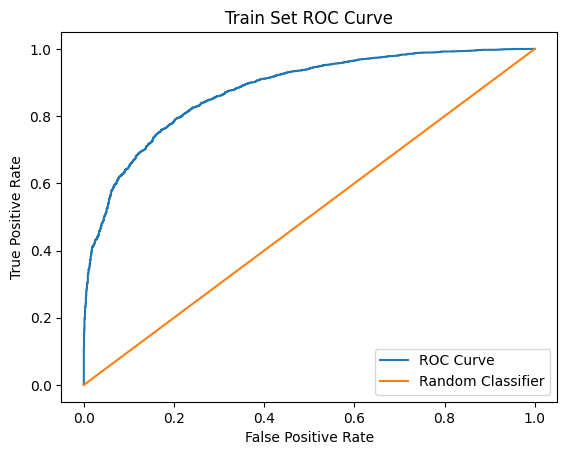

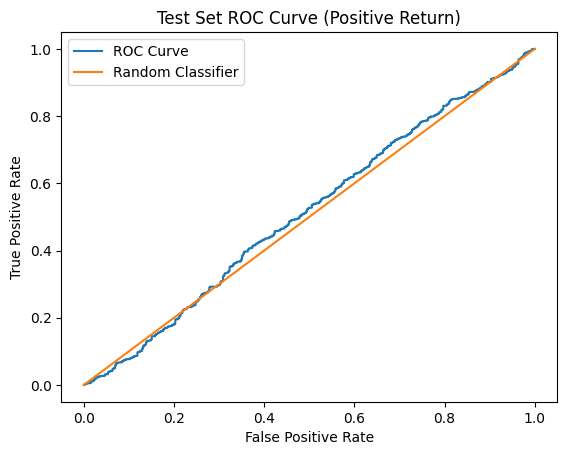

Train Set Confusion Matrix
[[2237  580]
 [ 665 2559]]
Test Set Confusion Matrix
[[178 512]
 [189 632]]


In [4]:
# ROC curve for probability of positive return
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]

plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Set ROC Curve')
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve (Positive Return)')
plt.legend()
plt.show()

# Confusion matrix
y_pred_train = (y_prob_train > best_threshold).astype(int)
y_pred_test = (y_prob_test > best_threshold).astype(int)

print('Train Set Confusion Matrix')
print(confusion_matrix(y_train, y_pred_train))
print('Test Set Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

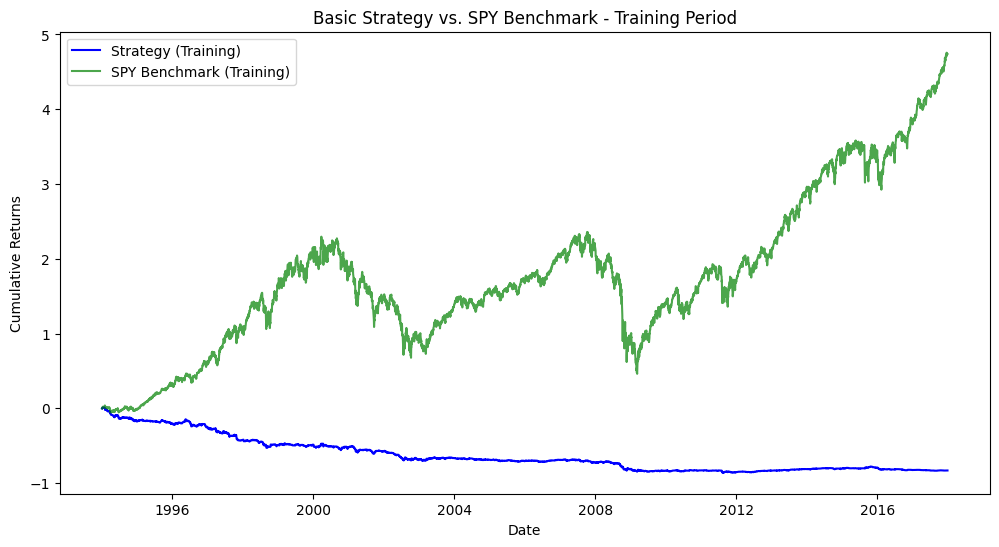

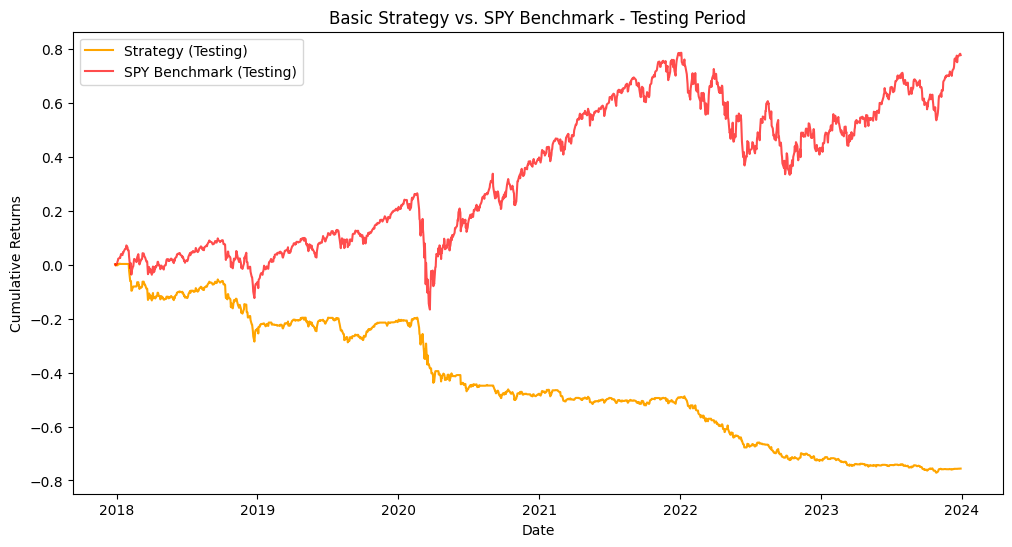

In [5]:
# Basic Buy/Sell Strategy performance without shorting
def calculate_strategy_daily_returns(predictions, actual_returns):
    return np.where(predictions == 1, actual_returns, 0)

strategy_daily_returns_train = calculate_strategy_daily_returns(y_pred_train, X_train['Return'])
strategy_daily_returns_test = calculate_strategy_daily_returns(y_pred_test, X_test['Return'])

def calculate_cumulative_returns(daily_returns):
    return (1 + daily_returns).cumprod() - 1

strategy_cumulative_returns_train = calculate_cumulative_returns(strategy_daily_returns_train)
strategy_cumulative_returns_test = calculate_cumulative_returns(strategy_daily_returns_test)
spy_cumulative_returns_train = calculate_cumulative_returns(X_train['Return'])
spy_cumulative_returns_test = calculate_cumulative_returns(X_test['Return'])

# Training Data
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, strategy_cumulative_returns_train, label='Strategy (Training)', color='blue')
plt.plot(X_train.index, spy_cumulative_returns_train, label='SPY Benchmark (Training)', color='green', alpha=0.7)
plt.title('Basic Strategy vs. SPY Benchmark - Training Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Testing Data
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, strategy_cumulative_returns_test, label='Strategy (Testing)', color='orange')
plt.plot(X_test.index, spy_cumulative_returns_test, label='SPY Benchmark (Testing)', color='red', alpha=0.7)
plt.title('Basic Strategy vs. SPY Benchmark - Testing Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [6]:
# Dual Threshold Strategy
def dual_thres_strat(signals, actual_returns, t1, t2):
    strategy_holdings = np.zeros(len(signals))
    
    # First day
    if signals[0] > t2:
        strategy_holdings[0] = 1  # buy
    elif signals[0] < t1:
        strategy_holdings[0] = -1  # short
    else:
        strategy_holdings[0] = 0  # no action
    
    # Subsequent days
    for i in range(1, len(strategy_holdings)):
        if signals[i] > t2:
            strategy_holdings[i] = 1 # buy
        elif signals[i] < t1:
            strategy_holdings[i] = -1 # short
        else:
            strategy_holdings[i] = 0.5 * strategy_holdings[i-1] # half of previous position

    strategy_returns = np.zeros(len(actual_returns))
    strategy_returns[1:] = strategy_holdings[:-1] * actual_returns[1:]
    return strategy_returns

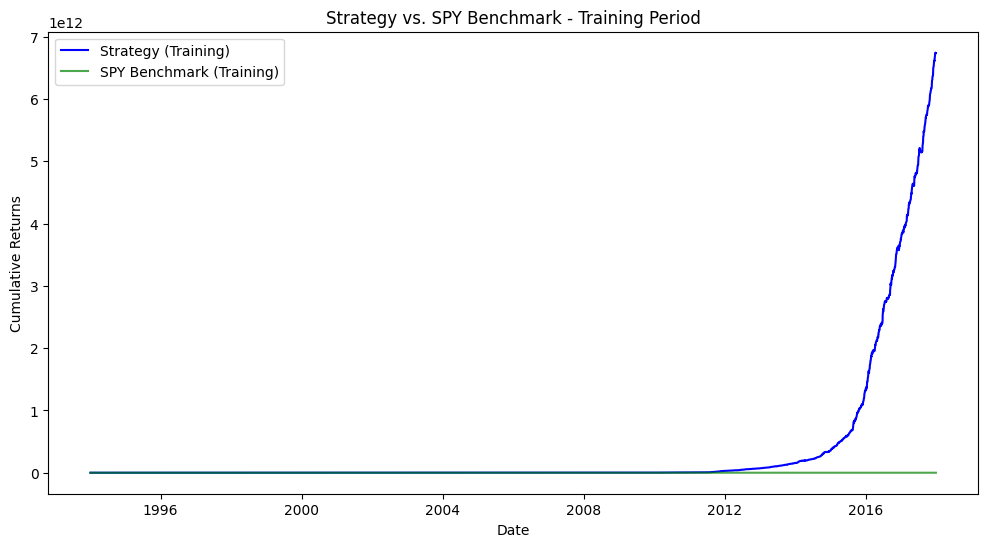

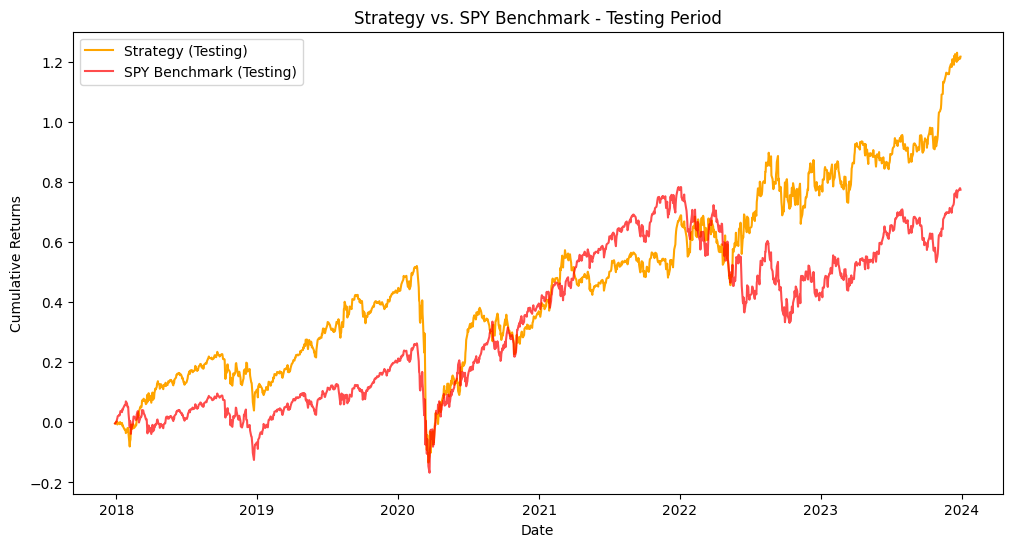

In [7]:
t1 = 0.25  # Threshold for shorting
t2 = 0.5  # Threshold for buying

strategy_returns_train = dual_thres_strat(y_pred_train, X_train['Return'].values, t1, t2)
strategy_returns_test = dual_thres_strat(y_pred_test, X_test['Return'].values, t1, t2)

strategy_cumulative_returns_train = calculate_cumulative_returns(strategy_returns_train)
strategy_cumulative_returns_test = calculate_cumulative_returns(strategy_returns_test)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(X_train.index[1:], strategy_cumulative_returns_train[1:], label='Strategy (Training)', color='blue')
plt.plot(X_train.index[1:], calculate_cumulative_returns(X_train['Return'].values[1:]), label='SPY Benchmark (Training)', color='green', alpha=0.7)
plt.title('Strategy vs. SPY Benchmark - Training Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(X_test.index[1:], strategy_cumulative_returns_test[1:], label='Strategy (Testing)', color='orange')
plt.plot(X_test.index[1:], calculate_cumulative_returns(X_test['Return'].values[1:]), label='SPY Benchmark (Testing)', color='red', alpha=0.7)
plt.title('Strategy vs. SPY Benchmark - Testing Period')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

Backtesting month 1 of 20...


/var/folders/wf/zzbnjjx54cvg4c5gt3fvz7tc0000gn/T/ipykernel_20062/201524435.py:33: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  strategy_returns = pd.concat([


Backtesting month 2 of 20...
Backtesting month 3 of 20...
Backtesting month 4 of 20...
Backtesting month 5 of 20...
Backtesting month 6 of 20...
Backtesting month 7 of 20...
Backtesting month 8 of 20...
Backtesting month 9 of 20...
Backtesting month 10 of 20...
Backtesting month 11 of 20...
Backtesting month 12 of 20...
Backtesting month 13 of 20...
Backtesting month 14 of 20...
Backtesting month 15 of 20...
Backtesting month 16 of 20...
Backtesting month 17 of 20...
Backtesting month 18 of 20...
Backtesting month 19 of 20...
Backtesting month 20 of 20...
Backtesting month 21 of 20...
Backtesting month 22 of 20...
Backtesting month 23 of 20...
Backtesting month 24 of 20...
Backtesting month 25 of 20...
Backtesting month 26 of 20...
Backtesting month 27 of 20...
Backtesting month 28 of 20...
Backtesting month 29 of 20...
Backtesting month 30 of 20...
Backtesting month 31 of 20...
Backtesting month 32 of 20...
Backtesting month 33 of 20...
Backtesting month 34 of 20...
Backtesting month 

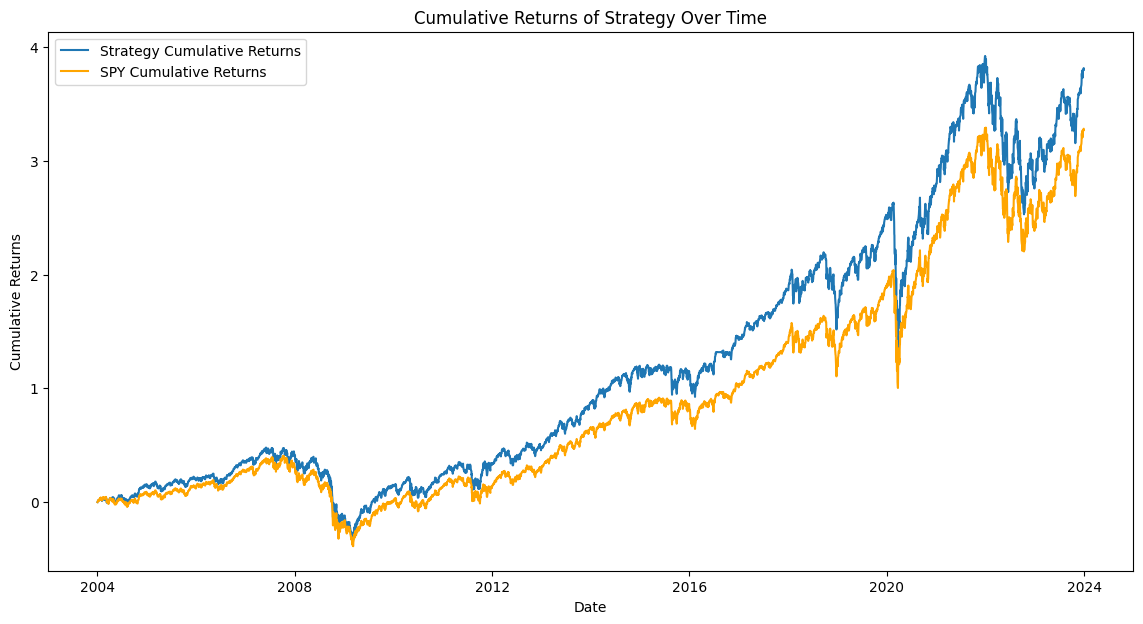

In [8]:
# Further backtest of dual threshold strategy using monthly model updates
strategy_returns = pd.Series(dtype=float)

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2024-01-01')
current_date = start_date
months = 0

while current_date < end_date:
    months += 1
    print(f'Backtesting month {months} of {end_date.year - start_date.year}...')

    # Define the training period (up until current_date)
    X_train = X.loc[:current_date]
    y_train = y.loc[:current_date]

    # Define the test period (the next month after current_date)
    next_month = (current_date + pd.DateOffset(months=1)).replace(day=1)
    X_test = X.loc[current_date:next_month]
    y_test = y.loc[current_date:next_month]

    # Train the XGBoost model
    model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)

    # Predict the probabilities for the test period
    y_prob_test = model.predict_proba(X_test)[:, 1]

    # Apply the dual-threshold strategy
    test_returns = dual_thres_strat(y_prob_test, X_test['Return'].values, t1, t2)

    # Store the strategy returns
    strategy_returns = pd.concat([
        strategy_returns,
        pd.Series(test_returns, index=X_test.index)
    ])
    # Move to the next month
    current_date = next_month

# Calculate the cumulative returns from the strategy
strategy_cumulative_returns = calculate_cumulative_returns(strategy_returns)
spy_cumulative_returns = calculate_cumulative_returns(X['Return'][start_date:end_date])

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(strategy_cumulative_returns.index, strategy_cumulative_returns, label='Strategy Cumulative Returns')
plt.plot(spy_cumulative_returns[start_date:].index, spy_cumulative_returns[start_date:], label='SPY Cumulative Returns', color='orange')
plt.title('Cumulative Returns of Strategy Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()